
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/master?urlpath=lab/tree/background_model.ipynb)
- You may download all the notebooks in the documentation as a [tar file](../_downloads/notebooks-dev.tar).
- **Source files:**
[background_model.ipynb](../_static/notebooks/background_model.ipynb) |
[background_model.py](../_static/notebooks/background_model.py)
</div>


# Create a template background model

## Context

DL3 data is usually shipped with a background IRF. However, sometimes it is necessary to be able to build background templates from scratch.

In this notebook, we show a very basic example of how this can be done using off runs supplied within the HESS data release.

Real life implementations can be found [here](https://www.aanda.org/articles/aa/abs/2019/12/aa36452-19/aa36452-19.html) and a slightly different approach [here](https://www.aanda.org/articles/aa/full_html/2019/12/aa36010-19/aa36010-19.html).

## Proposed approach


We will use the "off observations", i.e. those without significant gamma-ray emission sources in the field of view from the [H.E.S.S. first public test data release](https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/). This model could then be used in the analysis of sources from that dataset (not done here).

We will make a background model that is radially symmetric in the field of view, i.e. only depends on field of view offset angle and energy. At the end, we will save the model in the `BKG_2D` as defined in the [spec](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/full_enclosure/bkg/index.html).

Note that this is just a very simplified example. Actual background model production is done with more sophistication usually using 100s or 1000s of off runs, e.g. concerning non-radial symmetries, binning and smoothing of the distributions, and treating other dependencies such as zenith angle, telescope configuration or optical efficiency. Another aspect not shown here is how to use AGN observations to make background models, by cutting out the part of the field of view that contains gamma-rays from the AGN.

We will mainly be using the following classes:
        
* `~gammapy.data.DataStore` to load the runs to use to build the bkg model.
* `~gammapy.irf.Background2D` to represent and write the background model.

## Setup

As always, we start the notebook with some setup and imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from copy import deepcopy
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, vstack

In [3]:
from pathlib import Path
from gammapy.maps import MapAxis
from gammapy.data import DataStore
from gammapy.irf import Background2D

## Select off data

We start by selecting the observations used to estimate the background model.

In this case, we just take all "off runs" as defined in the observation table.

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
# Select just the off data runs
obs_table = data_store.obs_table
obs_table = obs_table[obs_table["TARGET_NAME"] == "Off data"]
observations = data_store.get_observations(obs_table["OBS_ID"])
print("Number of observations:", len(observations))

Number of observations: 45


## Background model

The background model we will estimate is a differential background rate model in unit `s-1 MeV-1 sr-1` as a function of reconstructed energy and field of fiew offset.

We estimate it by histogramming off data events and then smoothing a bit (not using a good method) to get a less noisy estimate. To get the differential rate, we divide by observation time and also take bin sizes into account to get the rate per energy and solid angle. So overall we fill two arrays called `counts` and `exposure` with `exposure` filled so that `background_rate = counts / exposure` will give the final background rate we're interested in.

The processing can be done either one observation at a time, or first for counts and then for exposure. Either way is fine. Here we do one observation at a time, starting with empty histograms and then accumulating counts and exposure. Since this is a multi-step algorithm, we put the code to do this computation in a `BackgroundModelEstimator` class.


In [5]:
class BackgroundModelEstimator:
    """"""

    def __init__(self, energy, offset):
        self.counts = self._make_bkg2d(energy, offset, unit="")
        self.exposure = self._make_bkg2d(energy, offset, unit="s MeV sr")

    @staticmethod
    def _make_bkg2d(energy, offset, unit):
        shape = len(energy.center), len(offset.center)
        return Background2D(axes=[energy, offset], unit=unit)

    def run(self, observations):
        for obs in observations:
            self.fill_counts(obs)
            self.fill_exposure(obs)

    def fill_counts(self, obs):
        events = obs.events
        energy_bins = self.counts.axes["energy"].edges
        offset_bins = self.counts.axes["offset"].edges

        counts = np.histogram2d(
            x=events.energy.to("MeV"),
            y=events.offset.to("deg"),
            bins=(energy_bins, offset_bins),
        )[0]
        self.counts.data += counts

    def fill_exposure(self, obs):
        axes = self.exposure.axes
        offset = axes["offset"].center
        time = obs.observation_time_duration
        exposure = 2 * np.pi * offset * time * axes.bin_volume()
        self.exposure.quantity += exposure

    @property
    def background_rate(self):
        rate = deepcopy(self.counts)
        rate.quantity /= self.exposure.quantity
        return rate

In [6]:
%%time
energy = MapAxis.from_energy_bounds(0.1, 100, 20, name="energy", unit="TeV")
offset = MapAxis.from_bounds(
    0, 3, nbin=9, interp="sqrt", unit="deg", name="offset"
)
estimator = BackgroundModelEstimator(energy, offset)
estimator.run(observations)

CPU times: user 2.4 s, sys: 31.3 ms, total: 2.43 s
Wall time: 2.43 s


Let's have a quick look at what we did ...

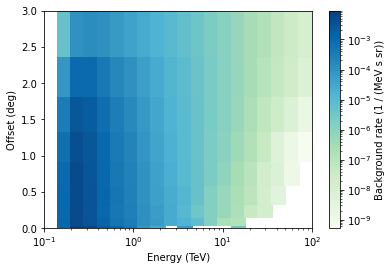

In [7]:
estimator.background_rate.plot()

In [8]:
# You could save the background model to a file like this
# estimator.background_rate.to_fits().writeto('background_model.fits', overwrite=True)

## Zenith dependence

The background models used in H.E.S.S. usually depend on the zenith angle of the observation. That kinda makes sense because the energy threshold increases with zenith angle, and since the background is related to (but not given by) the charged cosmic ray spectrum that is a power-law and falls steeply, we also expect the background rate to change.

Let's have a look at the dependence we get for this configuration used here (Hillas reconstruction, standard cuts, see H.E.S.S. release notes for more information).

Text(0, 0.5, 'Energy threshold (TeV)')

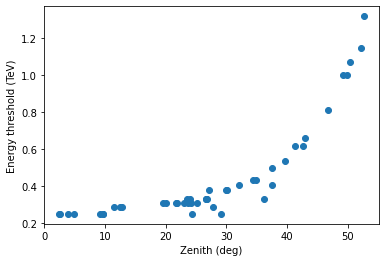

In [9]:
x = obs_table["ZEN_PNT"]
y = obs_table["SAFE_ENERGY_LO"]
plt.plot(x, y, "o")
plt.xlabel("Zenith (deg)")
plt.ylabel("Energy threshold (TeV)");

(0.0, 10.0)

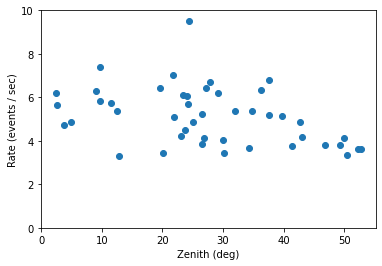

In [10]:
x = obs_table["ZEN_PNT"]
y = obs_table["EVENT_COUNT"] / obs_table["ONTIME"]
plt.plot(x, y, "o")
plt.xlabel("Zenith (deg)")
plt.ylabel("Rate (events / sec)")
plt.ylim(0, 10);

The energy threshold increases, as expected. It's a bit surprising that the total background rate doesn't decreases with increasing zenith angle. That's a bit of luck for this configuration, and because we're looking at the rate of background events in the whole field of view. As shown below, the energy threshold increases (reducing the total rate), but the rate at a given energy increases with zenith angle (increasing the total rate). Overall the background does change with zenith angle and that dependency should be taken into account.

The remaining scatter you see in the plots above (in energy threshold and rate) is due to dependence on telescope optical efficiency, atmospheric changes from run to run and other effects. If you're interested in this, [2014APh....54...25H](https://ui.adsabs.harvard.edu/abs/2014APh....54...25H) has some infos. We'll not consider this futher.

When faced with the question whether and how to model the zenith angle dependence, we're faced with a complex optimisation problem: the closer we require off runs to be in zenith angle, the fewer off runs and thus event statistic we have available, which will lead do noise in the background model. The choice of zenith angle binning or "on-off observation mathching" strategy isn't the only thing that needs to be optimised, there's also energy and offset binnings and smoothing scales. And of course good settings will depend on the way you plan to use the background model, i.e. the science measurement you plan to do. Some say background modeling is the hardest part of IACT data analysis.

Here we'll just code up something simple: make three background models, one from the off runs with zenith angle 0 to 20 deg, one from 20 to 40 deg, and one from 40 to 90 deg.

In [11]:
zenith_bins = [
    {"min": 0, "max": 20},
    {"min": 20, "max": 40},
    {"min": 40, "max": 90},
]


def make_model(observations):
    energy = MapAxis.from_energy_bounds(
        0.1, 100, 20, name="energy", unit="TeV"
    )
    offset = MapAxis.from_bounds(
        0, 3, nbin=9, interp="sqrt", unit="deg", name="offset"
    )
    estimator = BackgroundModelEstimator(energy, offset)
    estimator.run(observations)
    return estimator.background_rate


def make_models():
    for zenith in zenith_bins:
        mask = zenith["min"] <= obs_table["ZEN_PNT"]
        mask &= obs_table["ZEN_PNT"] < zenith["max"]
        obs_ids = obs_table["OBS_ID"][mask]
        observations = data_store.get_observations(obs_ids)
        yield make_model(observations)

In [12]:
%%time
models = list(make_models())

CPU times: user 2.59 s, sys: 52 ms, total: 2.64 s
Wall time: 2.64 s


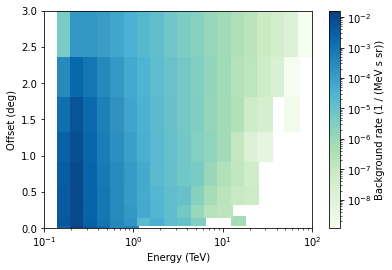

In [13]:
models[0].plot()

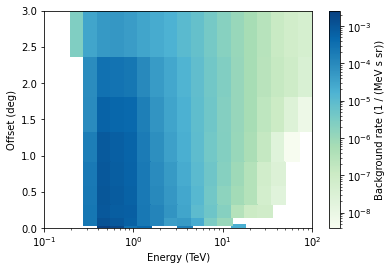

In [14]:
models[2].plot()

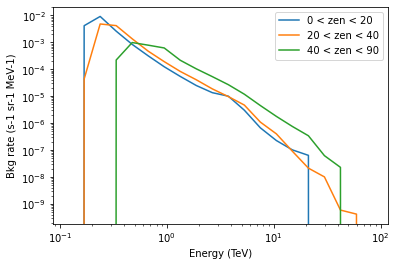

In [15]:
y = models[0].evaluate(energy=energy.center, offset="0.5 deg")
plt.plot(energy.center, y, label="0 < zen < 20")
y = models[1].evaluate(energy=energy.center, offset="0.5 deg")
plt.plot(energy.center, y, label="20 < zen < 40")
y = models[2].evaluate(energy=energy.center, offset="0.5 deg")
plt.plot(energy.center, y, label="40 < zen < 90")
plt.loglog()
plt.xlabel("Energy (TeV)")
plt.ylabel("Bkg rate (s-1 sr-1 MeV-1)")
plt.legend();

## Index tables

So now we have radially symmetric background models for three zenith angle bins. To be able to use it from the high-level Gammapy classes like e.g. the MapMaker though, we also have to create a [HDU index table](https://gamma-astro-data-formats.readthedocs.io/en/latest/data_storage/hdu_index/index.html) that declares which background model to use for each observation.

It sounds harder than it actually is. Basically you have to some code to make a new `astropy.table.Table`. The most tricky part is that before you can make the HDU index table, you have to decide where to store the data, because the HDU index table is a reference to the data location. Let's decide in this example that we want to re-use all existing files in `$GAMMAPY_DATA/hess-dl3-dr1` and put all the new HDUs (for background models and new index files) bundled in a single FITS file called `hess-dl3-dr3-with-background.fits.gz`, which we will put  in `$GAMMAPY_DATA/hess-dl3-dr1`.

In [16]:
filename = "hess-dl3-dr3-with-background.fits.gz"

# Make a new table with one row for each observation
# pointing to the background model HDU
rows = []
for obs_row in data_store.obs_table:
    row = {
        "OBS_ID": obs_row["OBS_ID"],
        "HDU_TYPE": "bkg",
        "HDU_CLASS": "bkg_2d",
        "FILE_DIR": "",
        "FILE_NAME": filename,
        "HDU_NAME": "BKG0",
    }
    rows.append(row)

hdu_table_bkg = Table(rows=rows)

In [17]:
# Make a copy of the original HDU index table
hdu_table = data_store.hdu_table.copy()
hdu_table.meta.pop("BASE_DIR")

# Add the rows for the background HDUs
hdu_table = vstack([hdu_table, hdu_table_bkg])
hdu_table.sort("OBS_ID")

In [18]:
hdu_table[8:14]

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE
int64,str6,str9,str4,str36,str6,int64
20137,bkg,bkg_3d,data,hess_dl3_dr1_obs_id_020137.fits.gz,bkg,207360
20137,edisp,edisp_2d,data,hess_dl3_dr1_obs_id_020137.fits.gz,edisp,377280
20137,events,events,data,hess_dl3_dr1_obs_id_020137.fits.gz,events,216000
20137,gti,gti,data,hess_dl3_dr1_obs_id_020137.fits.gz,gti,5760
20137,psf,psf_table,data,hess_dl3_dr1_obs_id_020137.fits.gz,psf,118080
20137,bkg,bkg_2d,,hess-dl3-dr3-with-background.fits.gz,BKG0,--


In [19]:
# Put index tables and background models in a FITS file
hdu_list = fits.HDUList()

hdu = fits.BinTableHDU(hdu_table)
hdu.name = "HDU_INDEX"
hdu_list.append(hdu)

hdu = fits.BinTableHDU(data_store.obs_table)
hdu_list.append(hdu)

for idx, model in enumerate(models):
    hdu = model.to_table_hdu()
    hdu.name = f"BKG{idx}"
    hdu_list.append(hdu)

print([_.name for _ in hdu_list])

import os

path = (
    Path(os.environ["GAMMAPY_DATA"])
    / "hess-dl3-dr1/hess-dl3-dr3-with-background.fits.gz"
)
hdu_list.writeto(path, overwrite=True)

['PRIMARY', 'HDU_INDEX', 'OBS_INDEX', 'BKG0', 'BKG1', 'BKG2']


In [20]:
# Let's see if it's possible to access the data
ds2 = DataStore.from_file(path)
ds2.info()
obs = ds2.obs(20137)

Found multiple HDU matching: OBS_ID = 20137, HDU_TYPE = bkg, HDU_CLASS = None. Returning the first entry, which has HDU_TYPE = bkg and HDU_CLASS = bkg_3d


Data store:
HDU index table:
BASE_DIR: /home/runner/work/gammapy-docs/gammapy-docs/gammapy-datasets/hess-dl3-dr1
Rows: 735
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


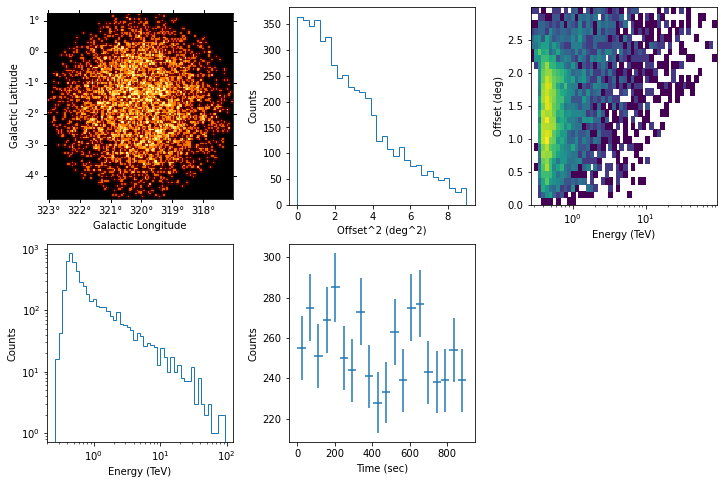

In [21]:
# the events
obs.events.select_offset([0, 3] * u.deg).peek()

/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/irf/effective_area.py:470: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  caxes = ax.pcolormesh(energy.value, offset.value, aeff.value.T, **kwargs)
/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


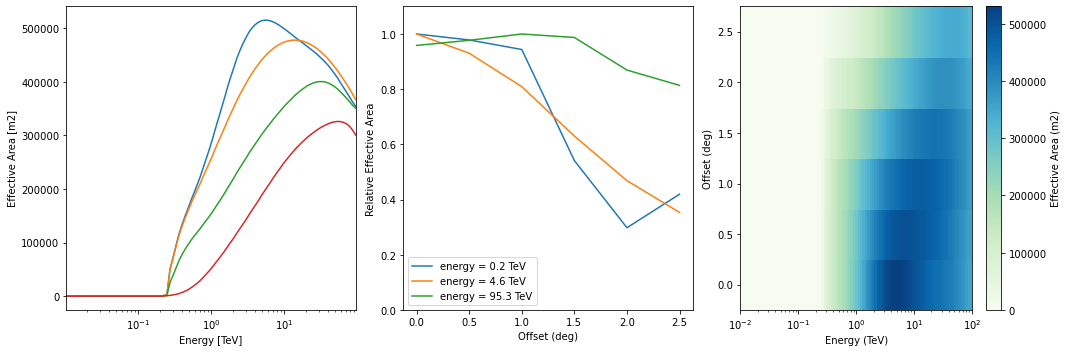

In [22]:
# the effective area
obs.aeff.peek()

/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


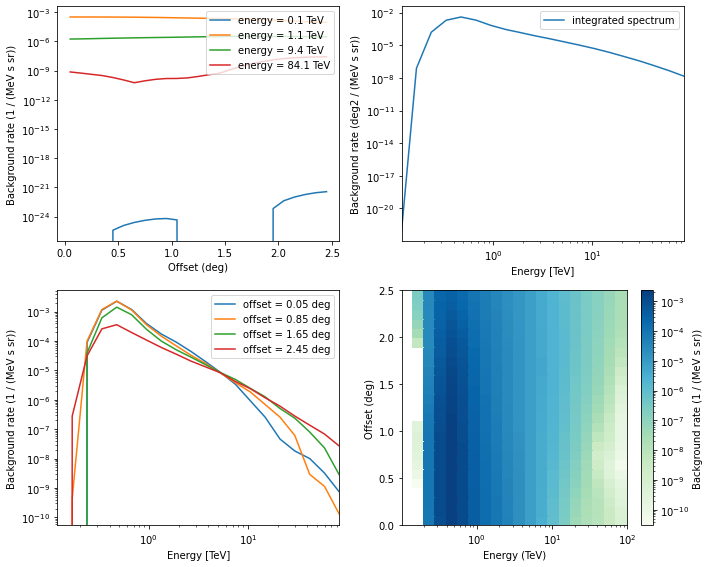

In [23]:
# the background
obs.bkg.peek()

## Exercises

- Play with the parameters here (energy binning, offset binning, zenith binning)
- Try to figure out why there are outliers on the zenith vs energy threshold curve.
- Does azimuth angle or optical efficiency have an effect on background rate?
- Use the background models for a 3D analysis (see "hess" notebook).